# Transfer Learning with TensorFlow: Fine-Tuning

In [1]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, walk_through_dir

## Get data

In [2]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [3]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [4]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [5]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [6]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [7]:
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[182.20345  184.20345  199.20345 ]
   [206.9104   208.9104   223.9104  ]
   [168.76021  172.40306  186.76021 ]
   ...
   [199.90111  206.90111  216.90111 ]
   [198.39886  205.39886  215.39886 ]
   [187.09262  194.09262  204.09262 ]]

  [[182.78444  185.03891  200.03891 ]
   [206.64157  208.89604  223.89604 ]
   [167.27806  170.92091  185.38712 ]
   ...
   [205.       212.       222.      ]
   [206.58542  213.58542  223.58542 ]
   [198.35254  205.35254  215.35254 ]]

  [[182.6926   185.6926   200.6926  ]
   [206.7618   209.7618   224.7618  ]
   [164.6065   169.24904  183.70154 ]
   ...
   [204.48502  211.48502  221.48502 ]
   [208.14095  215.14095  225.14095 ]
   [204.29836  211.29836  221.29836 ]]

  ...

  [[207.2229   211.2229   212.2229  ]
   [205.       209.       210.      ]
   [198.45247  202.45247  203.45247 ]
   ...
   [196.12338  200.12338  199.55191 ]
   [196.       200.       199.      ]
   [196.57587  200.57587  199.57587 ]]

  [[207.07143  211.07143  212.0714

## Model 0: Building a transfer learning model using the Keras Functional API

In [8]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
# 2. Freeze the model
base_model.trainable = False

# 3. Create inputs into the model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool of the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history_0 = model_0.fit(
    train_data_10_percent,
    steps_per_epoch=len(train_data_10_percent),
    epochs=20,
    verbose=True,
    callbacks=[
        create_tensorboard_callback("05_tensorboard_logs", "10_percent_feature_extraction")
    ],
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data))
)


Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: 05_tensorboard_logs/10_percent_feature_extraction/20210814-124040


C:\ProgramData\Anaconda3\envs\general_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/20
24/24 [==============================] - 18s 243ms/step - loss: 1.9393 - accuracy: 0.3787 - val_loss: 1.3537 - val_accuracy: 0.7319
Epoch 2/20
24/24 [==============================] - 3s 124ms/step - loss: 1.1525 - accuracy: 0.7400 - val_loss: 0.9286 - val_accuracy: 0.7993
Epoch 3/20
24/24 [==============================] - 3s 132ms/step - loss: 0.8531 - accuracy: 0.7987 - val_loss: 0.7523 - val_accuracy: 0.8224
Epoch 4/20
24/24 [==============================] - 3s 118ms/step - loss: 0.6981 - accuracy: 0.8333 - val_loss: 0.6463 - val_accuracy: 0.8438
Epoch 5/20
24/24 [==============================] - 3s 119ms/step - loss: 0.5897 - accuracy: 0.8573 - val_loss: 0.5802 - val_accuracy: 0.8701
Epoch 6/20
24/24 [==============================] - 3s 117ms/step - loss: 0.5231 - accuracy: 0.8840 - val_loss: 0.5725 - val_accuracy: 0.8487
Epoch 7/20
24/24 [==============================] - 3s 116ms/step - loss: 0.4667 - accuracy: 0.8987 - val_loss: 0.5633 - val_accuracy: 0.8454
Epoch

In [9]:
model_0.evaluate(test_data)

79/79 [==============================] - 5s 63ms/step - loss: 0.4375 - accuracy: 0.8576


[0.4375372529029846, 0.8575999736785889]

In [10]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [11]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [12]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


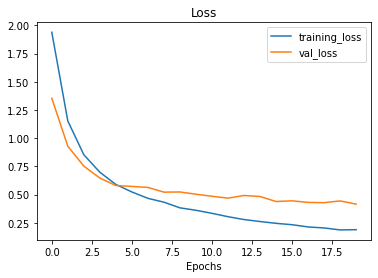

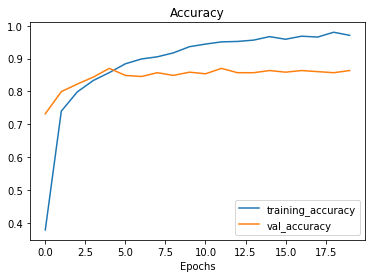

In [13]:
plot_loss_curves(history_0)

# Getting a feature vector from a trained model

Demonstrate the Global Average Pooling 2D layer

Similar shaped tensor (1,4,4,3) and pass it to GlobalAveragePooling2D

In [14]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(global_average_pooled_tensor.shape)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

(1, 3)
2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]



In [15]:
# Replicate the GlobalAveragePooling2D
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [16]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global max pooling 2D layer
global_max_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(global_max_pooled_tensor.shape)
print(f"2D global max pooled random tensor:\n {global_max_pooled_tensor}\n")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

(1, 3)
2D global max pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]



# Running a series of transfer learning experiments

1. `model_1` - use **feature extraction** *transfer learning* with **1%** of the training data with data augmentation
2. `model_2` - use **feature extraction** *transfer learning* with **10%** of the training with data augmentation
3. `model_3` - use **fine-tuning** *transfer learning* with **10%** of the training with data augmentation
4. `model_4` - use **fine-tuning** *transfer learning* with **100%** of the training with data augmentation

## Getting and preprocessing data for model_1

In [17]:
# Create training and test directories
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [18]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [19]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1_percent,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation into the model

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential(name="data_augmentation")
data_augmentation.add(preprocessing.RandomFlip("horizontal"))
data_augmentation.add(preprocessing.RandomZoom(0.2))
data_augmentation.add(preprocessing.RandomRotation(0.2))
data_augmentation.add(preprocessing.RandomHeight(0.2))
data_augmentation.add(preprocessing.RandomWidth(0.2))
# data_augmentation.add(preprocessing.Rescaling(1./255))


## Visualize data augmentation layer

568994.jpg
(306, 512, 3)


Text(0.5, 1.0, 'Augmented random image from: sushi')

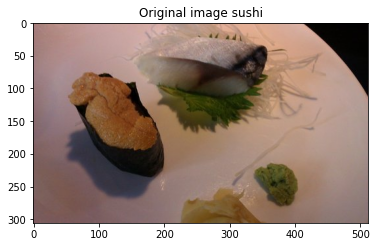

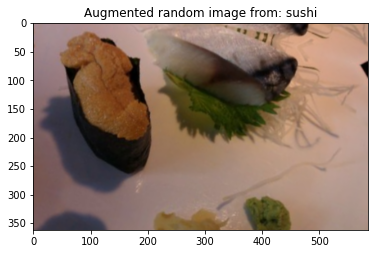

In [21]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
img = random.choice([x for x in os.listdir(target_dir)
               if os.path.isfile(os.path.join(target_dir, x))])
print(img)
img = mpimg.imread(target_dir +'/' +img)
plt.imshow(img, cmap=plt.cm.Blues)
plt.title(f"Original image {target_class}")
print(img.shape)
# Plot augmented image
augmented_image = data_augmentation(tf.expand_dims(img, axis=0))
augmented_image = augmented_image/255
plt.figure()
plt.imshow(tf.squeeze(augmented_image))
plt.title(f"Augmented random image from: {target_class}")


#  model_1: Feature extraction transfer learning on 1% of the data with data augmentation

In [22]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data_1_percent,
                    epochs=20,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("05_tensorboard_logs", "1_percent_data_aug")])

Saving TensorBoard log files to: 05_tensorboard_logs/1_percent_data_aug/20210814-124206
Epoch 1/20
3/3 [==============================] - 12s 2s/step - loss: 2.4157 - accuracy: 0.1000 - val_loss: 2.2283 - val_accuracy: 0.1908
Epoch 2/20
3/3 [==============================] - 3s 1s/step - loss: 2.1758 - accuracy: 0.2714 - val_loss: 2.0968 - val_accuracy: 0.2697
Epoch 3/20
3/3 [==============================] - 2s 895ms/step - loss: 1.9698 - accuracy: 0.4143 - val_loss: 2.0047 - val_accuracy: 0.3503
Epoch 4/20
3/3 [==============================] - 3s 1s/step - loss: 1.8302 - accuracy: 0.4714 - val_loss: 1.9147 - val_accuracy: 0.3964
Epoch 5/20
3/3 [==============================] - 2s 967ms/step - loss: 1.7112 - accuracy: 0.6000 - val_loss: 1.8458 - val_accuracy: 0.4375
Epoch 6/20
3/3 [==============================] - 2s 927ms/step - loss: 1.5776 - accuracy: 0.5857 - val_loss: 1.7602 - val_accuracy: 0.4688
Epoch 7/20
3/3 [==============================] - 2s 982ms/step - loss: 1.4836 -

In [23]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [24]:
model_1.evaluate(test_data)

79/79 [==============================] - 5s 58ms/step - loss: 1.1651 - accuracy: 0.6772


[1.1650612354278564, 0.6772000193595886]

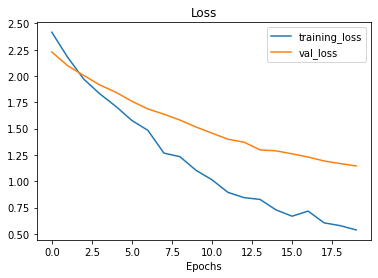

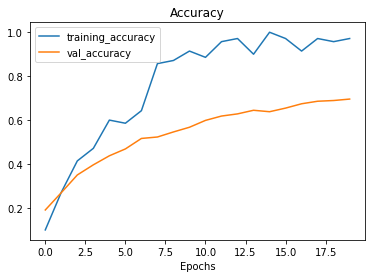

In [25]:
plot_loss_curves(history_1)

#  model_2: Feature extraction transfer learning on 10% of the data with data augmentation

In [26]:
# Create training and test directories
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [27]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [28]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10_percent,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [33]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_2 = keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

## Creating a ModelCheckpoint callback

In [34]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    save_freq="epoch",
    verbose=1,
)


In [35]:
initial_epochs = 20
history_2 = model_2.fit(
    train_data_10_percent,
    epochs=initial_epochs,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),  # validate for less steps
    # Track model training logs
    callbacks=[
        create_tensorboard_callback("05_tensorboard_logs", "10_percent_data_aug"),
        checkpoint_callback,
    ],
)


Saving TensorBoard log files to: 05_tensorboard_logs/10_percent_data_aug/20210814-124455
Epoch 1/20
24/24 [==============================] - 16s 378ms/step - loss: 1.9685 - accuracy: 0.3733 - val_loss: 1.4625 - val_accuracy: 0.6546

Epoch 00001: val_loss improved from inf to 1.46253, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
Epoch 2/20
24/24 [==============================] - 7s 278ms/step - loss: 1.3515 - accuracy: 0.6587 - val_loss: 1.0382 - val_accuracy: 0.7812

Epoch 00002: val_loss improved from 1.46253 to 1.03825, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
Epoch 3/20
24/24 [==============================] - 7s 284ms/step - loss: 1.0513 - accuracy: 0.7373 - val_loss: 0.8652 - val_accuracy: 0.7862

Epoch 00003: val_loss improved from 1.03825 to 0.86519, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
Epoch 4/20
24/24 [==============================] - 7s 277ms/step - loss: 0.8960 - accuracy: 0.7773 - val_l

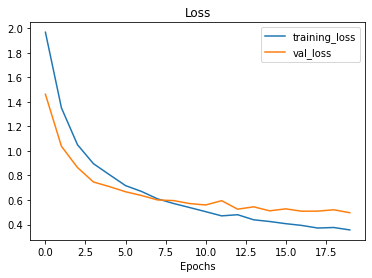

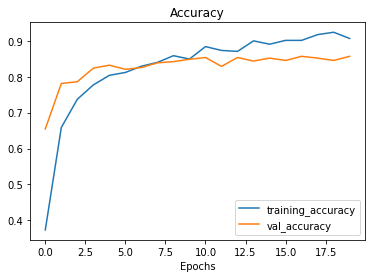

In [36]:
plot_loss_curves(history_2)

## Loading in checkpointed weights

In [37]:
# Load in saved_model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [38]:
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 5s 62ms/step - loss: 0.4981 - accuracy: 0.8444


# Model 3: Fine-tuning an existing model on 10% of the data

In [39]:
# Layers in loaded model
model_2.layers

In [40]:
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000021552FFAE20> True
<keras.engine.sequential.Sequential object at 0x00000214D8B01310> True
<keras.engine.functional.Functional object at 0x00000215556EA1F0> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x0000021552F37610> True
<keras.layers.core.Dense object at 0x00000215557BBBE0> True


In [44]:
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)


0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [45]:
print(len(model_2.layers[2].trainable_variables))

0


In [47]:
# To begin fine-tuning, set the last 10 layer of the base_model to true
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile (must recompile the model every time a change is made)
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning typically  want to lower the lr by 10x
    metrics=["accuracy"],
)


In [48]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [49]:
print(len(model_2.trainable_variables))

12


In [ ]:
model_2.trainable_variables